In [67]:
import pandas as pd

from google.protobuf import __version__ as pb_ver
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os

In [68]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPU detected: ",len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

Number of GPU detected:  0


In [69]:
# Move to Root
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Get Data directory inside root
DATA_DIR  = os.path.join(ROOT, 'data')

CLASSES = sorted(
    c for c in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, c))
        
)
print(CLASSES)

['Cat', 'Dog']


In [70]:
import os
import cv2, imghdr

ALLOWED_TYPES = {'jpg', 'jpeg', 'png', 'bmp'}

scanned = 0
deleted_corrupted = 0
deleted_ext = 0
deleted_2ch = 0


for cls in CLASSES:
    class_path = os.path.join(DATA_DIR, cls)

    

    for fname in os.listdir(class_path):
        fpath = os.path.join(class_path, fname)

        # Skip directories or weird entries
        if not os.path.isfile(fpath):
            continue

        try:
            # 1) Try to read the image
            img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
            scanned += 1

            # Corrupted / unreadable
            if img is None:
                try:
                    os.remove(fpath)
                    deleted_corrupted += 1
                except Exception as re:
                    print("Failed to remove (corrupted):", fpath, "|", re)
                continue

            # 2) Check actual file type (signature), not just extension
            file_type = imghdr.what(fpath)
            if file_type is None or file_type.lower() not in ALLOWED_TYPES:
                try:
                    os.remove(fpath)
                    deleted_ext += 1
                except Exception as re:
                    print("Failed to remove (bad_ext):", fpath, "|", re)
                continue

            # 3) Channel check — remove specifically 2-channel images
            #    img.ndim == 2 -> grayscale (1 channel)
            #    img.ndim == 3 -> img.shape[2] is channel count (3=BGR, 4=BGRA, 2=rare)
            if img.ndim == 2:
                channels = 1
            else:
                channels = img.shape[2]

            if channels == 2:
                try:
                    os.remove(fpath)
                    deleted_2ch += 1
                except Exception as re:
                    print("Failed to remove (2-channel):", fpath, "|", re)
                continue

        except Exception as e:
            # Any unexpected error → try to remove as a bad file
            try:
                os.remove(fpath)
                deleted_corrupted += 1
            except Exception as re:
                print("Failed to remove (exception):", fpath, "|", e, "|", re)

print("=== Clean-up Summary ===")
print("Files scanned        :", scanned)
print("Removed - corrupted  :", deleted_corrupted)
print("Removed - bad type   :", deleted_ext)
print("Removed - 2-channel  :", deleted_2ch)


=== Clean-up Summary ===
Files scanned        : 10019
Removed - corrupted  : 0
Removed - bad type   : 0
Removed - 2-channel  : 0


In [71]:
# Recalculate file counts after cleanup
final_counts = {
    cls: len([f for f in os.listdir(os.path.join(DATA_DIR, cls)) 
              if os.path.isfile(os.path.join(DATA_DIR, cls, f))])
    for cls in CLASSES
}
print("Final file counts:", final_counts)
print("Total number of files:", sum(final_counts.values()) )

Final file counts: {'Cat': 5030, 'Dog': 4989}
Total number of files: 10019


In [80]:
IMG_SIZE = (224,224) # Resize all the images to this shape
BATCH_SIZE = 32
SEED = 42 # For reproductibility

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split = 0.2,
    subset = 'training',
    seed =SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split = 0.2,
    subset='validation',
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

class_names = train_ds.class_names

print("Classes:", train_ds.class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches  :", tf.data.experimental.cardinality(val_ds).numpy())

Found 10019 files belonging to 2 classes.
Using 8016 files for training.
Found 10019 files belonging to 2 classes.
Using 2003 files for validation.
Classes: ['Cat', 'Dog']
Train batches: 251
Validation batches  : 63


In [81]:
# Split validation into test + new Validation 
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
print('Total val batches:',val_batches)

# Take half of val_ds as test set
test_ds = val_ds.take(val_batches// 2)

#Keep other half as real validation set
val_ds = val_ds.skip(val_batches //2)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

Total val batches: 63
Train batches: 251
Validation batches: 32
Test batches: 31


In [82]:
# Optimize input pipeline

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

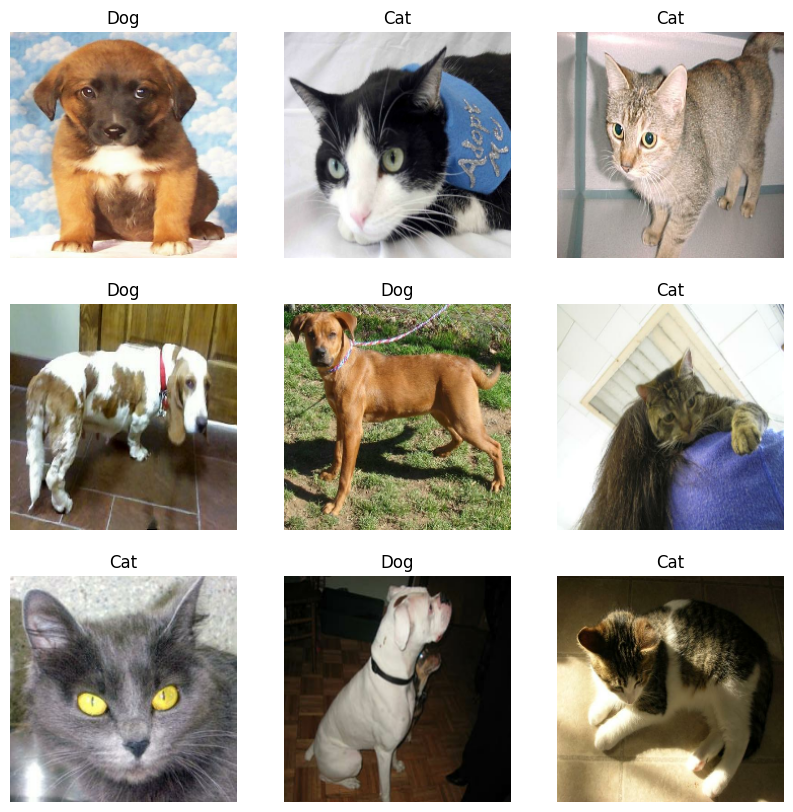

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):   # take 1 batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [90]:

from tensorflow.keras import layers, models
# --- Normalization + Augmentation ---
normalization_layer = layers.Rescaling(1./255 , input_shape = (224,224,3))

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


#-----------MODEL DEFINITION-----------

model = models.Sequential([
    normalization_layer,
    data_augmentation,

    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPooling2D(),

   
    layers.Conv2D(64,3, activation='relu'),
    layers.MaxPooling2D(), 

    layers.Flatten(),

    layers.Dense(63, activation='relu'),
    layers.Dense(1, activation='sigmoid'),

])



#-----Compile-----

model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


model.summary()

c:\Users\HP\anaconda3\envs\imagecnn_env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 63)             │     2,725,695 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            64 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,749,343 (10.49 MB)

 Trainable params: 2,749,343 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 313ms/step - accuracy: 0.5929 - loss: 0.6687 - val_accuracy: 0.6330 - val_loss: 0.6417
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 281ms/step - accuracy: 0.6521 - loss: 0.6213 - val_accuracy: 0.7300 - val_loss: 0.5448
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.7056 - loss: 0.5716 - val_accuracy: 0.6785 - val_loss: 0.5980
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.7254 - loss: 0.5396 - val_accuracy: 0.7488 - val_loss: 0.4964
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 75s 297ms/step - accuracy: 0.7350 - loss: 0.5228 - val_accuracy: 0.7448 - val_loss: 0.5152
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.7541 - loss: 0.4984 - val_accuracy: 0.7735 - val_loss: 0.4628
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 276ms/step - accuracy: 0.7585 - loss: 0.4861 - val_accuracy: 0.7864 - val_loss: 0.4598
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 283ms/step - accuracy: 0.7767 - loss: 0

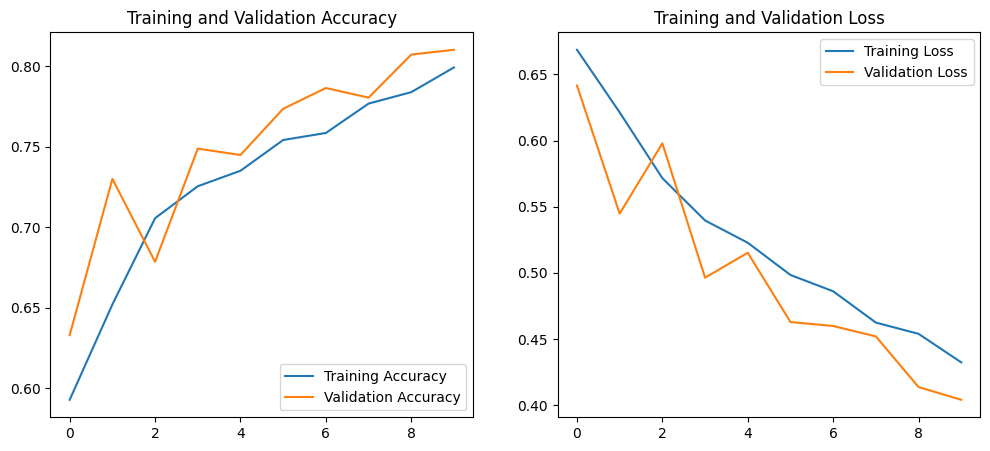

In [92]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [93]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8024 - loss: 0.4389
Test accuracy: 0.8024193644523621


In [95]:
from tensorflow.keras.preprocessing import image

def prepare_image(img_path, img_size=(224,224,)):

    # Load image from path and resize
    img = image.load_img(img_path,target_size = img_size)

    # Convert to array 
    img_array = image.img_to_array(img)

    # Scale to [0,1]
    img_array = img_array / 255.0

    # Add batch dimension (model expects [batch , height, width, channels])

    img_array = np.expand_dims(img_array , axis = 0)

    return img_array

In [96]:
def predict_image(model, img_path, class_names):
    img_array = prepare_image(img_path)
    prediction = model.predict(img_array)[0][0]
    
    # Sigmoid output → threshold 0.5
    if prediction < 0.5:
        print(f"Prediction: {class_names[0]} ({1-prediction:.2%} confidence)")
    else:
        print(f"Prediction: {class_names[1]} ({prediction:.2%} confidence)")


In [101]:
print("Cat image-------------")
predict_image(model, "cat.jpg", class_names)
print("")
print("")

print("Dog image-------------")
predict_image(model, "dog.jpg", class_names)


Cat image-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction: Cat (99.30% confidence)


Dog image-------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: Cat (99.28% confidence)
